# EE P 555 - Winter26 - Regression Demo: Linear vs Polynomial (Degree 3) vs Sinusoidal

In this notebook, we will:
- Generate **three synthetic regression datasets**:
  1. Linear relationship
  2. Cubic polynomial relationship (degree 3)
  3. Sinusoidal relationship
- Fit **three model families** to each dataset using a **Linear Regressor**:
  - Linear Regression
  - Polynomial Regression (degree 3) using polynomial feature expansion
  - Sinusoidal Regression using features $[1, \sin(\omega x), \cos(\omega x)]$
- Evaluate models using a **train/test split** (70% train, 30% test) with two options:
  - **random** split (shuffled)
  - **ordered_contiguous** split (sort by $x$ low→high, then split)

We report:
- **RMSE**
- **$R^2$**

and visualize:
- Train vs test samples
- Ground truth function
- Fitted curves from each model


## 1) Imports

We use:
- `numpy` for data generation
- `matplotlib` for plotting
- `scikit-learn` for regression models, feature transforms, and evaluation metrics


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import train_test_split

## 2) Synthetic Data Generation

We create three synthetic regression datasets:

### (a) Linear dataset
$$
y = 2.5x - 1.0 + \epsilon
$$

### (b) Cubic (degree 3) dataset
$$
y = 0.8x^3 - 1.2x^2 + 0.4x + 0.5 + \epsilon
$$

### (c) Sinusoidal dataset
$$
y = 1.5\sin(\omega x) + 0.7\cos(\omega x) + 0.2 + \epsilon
$$

where $\epsilon$ is Gaussian noise.


In [ ]:
def make_linear(n=1000, x_range=(-10, 10), noise_std=0.6, seed=0):
    rng = np.random.default_rng(seed)
    x = rng.uniform(*x_range, size=n)
    y_true = 2.5 * x - 1.0
    y = y_true + rng.normal(0, noise_std, size=n)
    return x, y


def make_cubic(n=1000, x_range=(-10, 10), noise_std=0.8, seed=1):
    rng = np.random.default_rng(seed)
    x = rng.uniform(*x_range, size=n)
    y_true = 0.8 * x**3 - 1.2 * x**2 + 0.4 * x + 0.5
    y = y_true + rng.normal(0, noise_std, size=n)
    return x, y


def make_sinusoidal(n=1000, x_range=(0, 10*np.pi), noise_std=0.5, seed=2, omega=1.0):
    rng = np.random.default_rng(seed)
    x = rng.uniform(*x_range, size=n)
    y_true = 1.5 * np.sin(omega * x) + 0.7 * np.cos(omega * x) + 0.2
    y = y_true + rng.normal(0, noise_std, size=n)
    return x, y, omega


## 3) Train/Test Split Options

We support two splitting modes:

### (a) Random split (typical i.i.d. assumption)
- Shuffle the dataset
- Use 70% for training, 30% for testing

### (b) Ordered contiguous split (sort by x then split)
- Sort samples by $x$ from low to high
- Use the first 70% (low-x region) for training
- Use the last 30% (high-x region) for testing

This ordered split is useful to illustrate **interpolation vs extrapolation** behavior.


In [ ]:
def split_train_test(x, y, train_frac=0.7, split_mode="random", seed=42):
    """
    split_mode:
      - "random": shuffle then split
      - "ordered_contiguous": sort by x ascending (low->high), then split
    """
    x = np.asarray(x)
    y = np.asarray(y)

    if not (0.0 < train_frac < 1.0):
        raise ValueError("train_frac must be between 0 and 1.")

    test_size = 1.0 - train_frac

    if split_mode == "random":
        x_train, x_test, y_train, y_test = train_test_split(
            x, y, test_size=test_size, random_state=seed, shuffle=True
        )
        return x_train, x_test, y_train, y_test

    if split_mode == "ordered_contiguous":
        idx = np.argsort(x)
        x_sorted = x[idx]
        y_sorted = y[idx]

        n = len(x_sorted)
        n_train = int(np.floor(train_frac * n))

        return (x_sorted[:n_train], x_sorted[n_train:],
                y_sorted[:n_train], y_sorted[n_train:])

    raise ValueError("split_mode must be 'random' or 'ordered_contiguous'.")


## 4) Model 1: Linear Regression

We fit a standard linear model:
$$
\hat{y} = \beta_0 + \beta_1 x
$$

This is implemented using `sklearn.linear_model.LinearRegression`.


In [ ]:
def fit_linear_regression(x_train, y_train):
    Xtr = x_train.reshape(-1, 1)
    model = LinearRegression()
    model.fit(Xtr, y_train)
    return model

## 5) Model 2: Polynomial Regression (Degree 3) using Linear Regression

Polynomial regression is implemented by **expanding features**:

$$
\phi(x) = [x,\; x^2,\; x^3]
$$

and then fitting:
$$
\hat{y} = \beta_0 + \beta_1 x + \beta_2 x^2 + \beta_3 x^3
$$

Even though the model is nonlinear in \(x\), it is still **linear in the parameters** \(\beta\), so we can use a linear regressor after feature expansion.

We implement this using:
- `PolynomialFeatures(degree=3)`
- `LinearRegression()`
in a scikit-learn `Pipeline`.


In [ ]:
def fit_polynomial_regression_degree3(x_train, y_train):
    Xtr = x_train.reshape(-1, 1)
    model = Pipeline([
        ("poly", PolynomialFeatures(degree=3, include_bias=False)),
        ("lr", LinearRegression())
    ])
    model.fit(Xtr, y_train)
    return model

## 6) Model 3: Sinusoidal Regression using Linear Regression

We fit a sinusoidal model using a linear regressor by defining basis features:
$$
\phi(x) = [1,\; \sin(\omega x),\; \cos(\omega x)]
$$

Model:
$$
\hat{y} = \beta_0 + \beta_1 \sin(\omega x) + \beta_2 \cos(\omega x)
$$

### Estimating $\omega$
If $\omega$ is unknown, we:
1. Try a grid of candidate values $\omega$
2. Fit a linear model for each $\omega$
3. Choose the $\omega$ that minimizes **training RMSE**

After selecting $\omega$, prediction is straightforward using the same sinusoidal design matrix.


In [ ]:
def sinusoid_design_matrix(x, omega):
    """Features: [1, sin(omega x), cos(omega x)]"""
    x = np.asarray(x)
    return np.column_stack([
        np.ones_like(x),
        np.sin(omega * x),
        np.cos(omega * x),
    ])


def fit_sinusoidal_regression(x_train, y_train, omega=None, omega_grid=None):
    """
    If omega is None, estimate omega via grid search minimizing TRAIN RMSE.
    """
    x_train = np.asarray(x_train)
    y_train = np.asarray(y_train)

    if omega is None:
        if omega_grid is None:
            omega_grid = np.linspace(0.1, 4.0, 200)

        best_omega = None
        best_rmse = np.inf
        best_model = None

        for w in omega_grid:
            Xw = sinusoid_design_matrix(x_train, w)
            m = LinearRegression(fit_intercept=False)  # intercept is in the design matrix
            m.fit(Xw, y_train)
            yhat = m.predict(Xw)
            rmse = np.sqrt(mean_squared_error(y_train, yhat))
            if rmse < best_rmse:
                best_rmse = rmse
                best_omega = w
                best_model = m

        return best_model, best_omega

    Xtr = sinusoid_design_matrix(x_train, omega)
    model = LinearRegression(fit_intercept=False)
    model.fit(Xtr, y_train)
    return model, omega

In [ ]:
def predict_any(model, x, kind, omega=None):
    x = np.asarray(x)
    if kind in ["linear", "poly3"]:
        return model.predict(x.reshape(-1, 1))
    elif kind == "sin":
        if omega is None:
            raise ValueError("omega must be provided for sinusoidal prediction.")
        return model.predict(sinusoid_design_matrix(x, omega))
    else:
        raise ValueError("Unknown kind")

## 7) Evaluation Metrics

We evaluate each model on **training** and **testing** sets using:

### RMSE
$
\mathrm{RMSE} = \sqrt{\frac{1}{n}\sum_{i=1}^{n}(y_i-\hat{y}_i)^2}
$

### $R^2$ score
$$
R^2 = 1 - \frac{\sum (y_i-\hat{y}_i)^2}{\sum (y_i-\bar{y})^2}
$$

We also visualize:
- Train vs test samples
- Ground truth curve (when known)
- Predicted curves from all three models


In [ ]:
def metrics(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    return rmse, r2


def run_one_dataset(
    name,
    x, y,
    x_plot,
    y_truth_plot=None,
    train_frac=0.7,
    split_mode="ordered_contiguous",  # "random" or "ordered_contiguous"
    seed=42
):
    # Split
    x_train, x_test, y_train, y_test = split_train_test(
        x, y, train_frac=train_frac, split_mode=split_mode, seed=seed
    )

    # Fit models on TRAIN ONLY
    m_lin = fit_linear_regression(x_train, y_train)
    m_poly = fit_polynomial_regression_degree3(x_train, y_train)
    m_sin, est_omega = fit_sinusoidal_regression(x_train, y_train, omega=None)

    # Predict on train/test
    yhat_lin_tr = predict_any(m_lin, x_train, "linear")
    yhat_poly_tr = predict_any(m_poly, x_train, "poly3")
    yhat_sin_tr = predict_any(m_sin, x_train, "sin", omega=est_omega)

    yhat_lin_te = predict_any(m_lin, x_test, "linear")
    yhat_poly_te = predict_any(m_poly, x_test, "poly3")
    yhat_sin_te = predict_any(m_sin, x_test, "sin", omega=est_omega)

    # Print metrics
    print(f"\n=== {name} dataset | split_mode={split_mode} | train={int(train_frac*100)}% test={int((1-train_frac)*100)}% ===")
    for model_name, ytr, yte in [
        ("Linear Reg      ", yhat_lin_tr, yhat_lin_te),
        ("Poly Reg (deg 3)", yhat_poly_tr, yhat_poly_te),
        ("Sinusoid Reg    ", yhat_sin_tr, yhat_sin_te),
    ]:
        rmse_tr, r2_tr = metrics(y_train, ytr)
        rmse_te, r2_te = metrics(y_test, yte)
        print(f"{model_name}: TRAIN RMSE={rmse_tr:.3f}, R2={r2_tr:.3f} | TEST RMSE={rmse_te:.3f}, R2={r2_te:.3f}")

    print(f"Sinusoid estimated omega (fit on TRAIN only): {est_omega:.3f}")

    # Split marker (only meaningful for ordered_contiguous)
    split_x = None
    if split_mode == "ordered_contiguous" and len(x_test) > 0:
        split_x = (x_train.max() + x_test.min()) / 2.0

    # Plot model curves
    yplot_lin = predict_any(m_lin, x_plot, "linear")
    yplot_poly = predict_any(m_poly, x_plot, "poly3")
    yplot_sin = predict_any(m_sin, x_plot, "sin", omega=est_omega)

    plt.figure(figsize=(8, 5))
    plt.scatter(x_train, y_train, alpha=0.7, label="Train")
    plt.scatter(x_test, y_test, alpha=0.7, label="Test")

    if split_x is not None:
        plt.axvline(split_x, linestyle="--", linewidth=2, label="Train/Test split")

    if y_truth_plot is not None:
        plt.plot(x_plot, y_truth_plot, linewidth=2, label="Ground truth")

    plt.plot(x_plot, yplot_lin, linewidth=2, label="Linear Regression")
    plt.plot(x_plot, yplot_poly, linewidth=2, label="Polynomial (deg 3)")
    plt.plot(x_plot, yplot_sin, linewidth=2, label="Sinusoidal Regression")

    plt.title(f"{name}: train/test evaluation ({split_mode})")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.legend()
    plt.tight_layout()
    plt.show()


## 8) Running One Dataset: Fit → Evaluate → Plot

For each dataset:
1. Split into train/test using the selected split mode
2. Fit the three models **using only the training data**
3. Compute RMSE and \(R^2\) on both train and test sets
4. Plot:
   - Train and test points
   - Ground truth curve (if available)
   - Curves from linear, polynomial, and sinusoidal regression

For the ordered contiguous split, we also draw a vertical line to show the train/test boundary in \(x\).


## 9) Main Experiment: Run All Datasets

We run the same modeling + evaluation pipeline on:

1. **Linear dataset**
2. **Cubic (degree 3) dataset**
3. **Sinusoidal dataset**

You can control:
- `SPLIT_MODE`: `"random"` or `"ordered_contiguous"`
- `TRAIN_FRAC`: typically `0.7`
- `SEED`: controls reproducibility for random split

At the end, we also print the true sinusoidal frequency \(\omega\) used to generate the sinusoidal dataset.



=== Linear dataset | split_mode=random | train=70% test=30% ===
Linear Reg      : TRAIN RMSE=0.608, R2=0.998 | TEST RMSE=0.633, R2=0.998
Poly Reg (deg 3): TRAIN RMSE=0.607, R2=0.998 | TEST RMSE=0.634, R2=0.998
Sinusoid Reg    : TRAIN RMSE=0.911, R2=0.996 | TEST RMSE=0.861, R2=0.996
Sinusoid estimated omega (fit on TRAIN only): 0.100


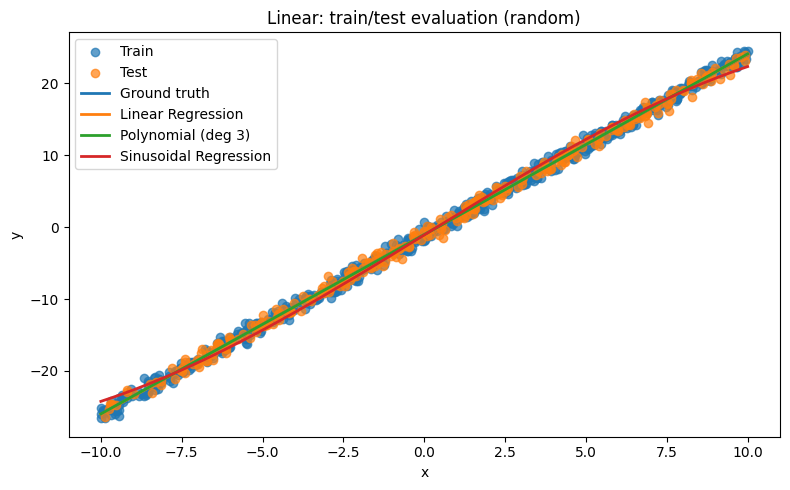


=== Cubic (degree 3) dataset | split_mode=random | train=70% test=30% ===
Linear Reg      : TRAIN RMSE=123.936, R2=0.826 | TEST RMSE=129.377, R2=0.832
Poly Reg (deg 3): TRAIN RMSE=0.815, R2=1.000 | TEST RMSE=0.838, R2=1.000
Sinusoid Reg    : TRAIN RMSE=132.639, R2=0.801 | TEST RMSE=135.615, R2=0.816
Sinusoid estimated omega (fit on TRAIN only): 0.100


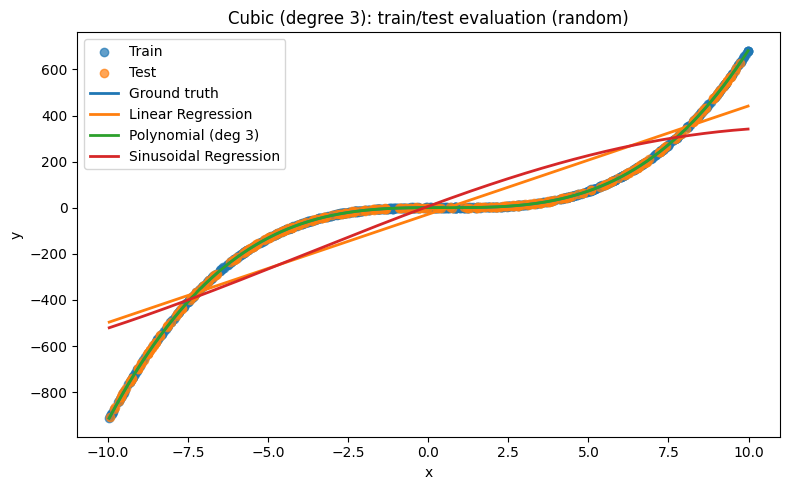


=== Sinusoidal dataset | split_mode=random | train=70% test=30% ===
Linear Reg      : TRAIN RMSE=1.250, R2=0.008 | TEST RMSE=1.285, R2=0.027
Poly Reg (deg 3): TRAIN RMSE=1.225, R2=0.047 | TEST RMSE=1.262, R2=0.062
Sinusoid Reg    : TRAIN RMSE=0.495, R2=0.845 | TEST RMSE=0.484, R2=0.862
Sinusoid estimated omega (fit on TRAIN only): 1.002


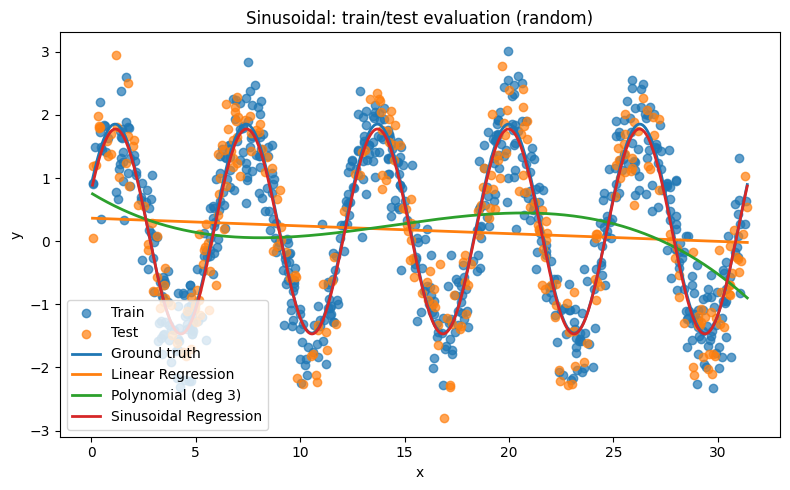


(For reference) True omega used to generate sinusoidal data: 1.000


In [ ]:
if __name__ == "__main__":
    # Choose split behavior here:
    SPLIT_MODE = "random"   # "random" or "ordered_contiguous"
    TRAIN_FRAC = 0.7                   # 70% train, 30% test
    SEED = 42                          # only used if SPLIT_MODE == "random"

    # 1) Linear dataset
    x1, y1 = make_linear(seed=0)
    x1_plot = np.linspace(x1.min(), x1.max(), 500)
    y1_truth_plot = 2.5 * x1_plot - 1.0
    run_one_dataset(
        "Linear", x1, y1, x1_plot,
        y_truth_plot=y1_truth_plot,
        train_frac=TRAIN_FRAC, split_mode=SPLIT_MODE, seed=SEED
    )

    # 2) Cubic dataset
    x2, y2 = make_cubic(seed=1)
    x2_plot = np.linspace(x2.min(), x2.max(), 500)
    y2_truth_plot = 0.8 * x2_plot**3 - 1.2 * x2_plot**2 + 0.4 * x2_plot + 0.5
    run_one_dataset(
        "Cubic (degree 3)", x2, y2, x2_plot,
        y_truth_plot=y2_truth_plot,
        train_frac=TRAIN_FRAC, split_mode=SPLIT_MODE, seed=SEED
    )

    # 3) Sinusoidal dataset
    x3, y3, omega_true = make_sinusoidal(seed=2, omega=1.0)
    x3_plot = np.linspace(x3.min(), x3.max(), 800)
    y3_truth_plot = 1.5 * np.sin(omega_true * x3_plot) + 0.7 * np.cos(omega_true * x3_plot) + 0.2
    run_one_dataset(
        "Sinusoidal", x3, y3, x3_plot,
        y_truth_plot=y3_truth_plot,
        train_frac=TRAIN_FRAC, split_mode=SPLIT_MODE, seed=SEED
    )

    print(f"\n(For reference) True omega used to generate sinusoidal data: {omega_true:.3f}")
